In [2]:
# ECT
import demeter.euler as euler
import demeter.directions as dirs
import demeter.misc as mis

In [3]:
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch

import matplotlib.pyplot as plt
import numpy as np

from gtda.plotting import plot_heatmap
from gtda.images import Binarizer

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, make_union
from sklearn.metrics import accuracy_score, adjusted_rand_score, classification_report
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier

from tqdm import tqdm
from joblib import Parallel, delayed

In [4]:
# logs file
import logging

logger = logging.getLogger()
if (logger.hasHandlers()):
    logger.handlers.clear()

# Configure logging to write to a file
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    filename='ect_on_CIFAR10.log',
    filemode='a' # 'a' for append, 'w' for overwrite each run
)

logging.info("="*50)
logging.info("NEW TRAINING RUN STARTED")
logging.info("="*50)

In [5]:
# Load Data
transform = transforms.Compose([
    transforms.ToTensor(),              # convert to tensor [0,1]
    #transforms.Normalize((0.5,), (0.5,)) # normalize to [-1,1]
])

CIFAR10_train_data = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
CIFAR10_test_data = datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)

CIFAR10_train_loader = DataLoader(CIFAR10_train_data, 128, True)
CIFAR10_test_loader = DataLoader(CIFAR10_test_data, 1000, True)

1

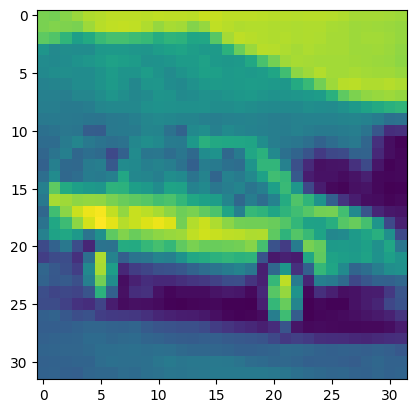

In [6]:
img, label = CIFAR10_train_data[4]
img_reshaped = img.permute(1, 2, 0).numpy()
plt.imshow(img_reshaped[:,:,2])
label

In [20]:
def _compute_safe_ect(binary_img, directions, num_thresholds, num_directions):
    """
    Safely computes the ECT for a binary image. 
    Returns a zero-vector if the image is empty or if the library fails.
    """
    if np.sum(binary_img) == 0:
        return np.zeros(num_directions * num_thresholds)

    try:
        seed = euler.CubicalComplex(binary_img).complexify()
        seed_coords = seed.cells[0]
        return seed.ECT(directions, T=num_thresholds, verts=seed_coords)
    except Exception:
        return np.zeros(num_directions * num_thresholds)


def _get_adaptive_thresholds(img, quantiles):
    """Calculates specific threshold values based on non-zero pixel distribution."""
    non_zero_pixels = img[img > 0.01]
    if non_zero_pixels.size == 0:
        return [0.0] * len(quantiles)
    return np.quantile(non_zero_pixels, quantiles)

In [21]:
def process_single_item(data_item, quantiles, directions, num_directions, num_thresholds):
    img_rgb_tensor, label = data_item
    img_rgb = img_rgb_tensor.numpy()
    
    image_ect_vectors = []
    # 1. Get Thresholds
    for channel in range(3): #3 channels
        img_gray = img_rgb[channel, :, :]
        thresholds = _get_adaptive_thresholds(img_gray, quantiles)
        
        # 2. Process Whole Image (Loop over all thresholds)
        for t_value in thresholds:
            img_binary = (img_gray > t_value).astype(int)
            
            ect_vec = _compute_safe_ect(
                img_binary, directions, num_thresholds, num_directions
            )
            image_ect_vectors.append(ect_vec)
    final_ect_vector = np.concatenate(image_ect_vectors)
    
    return final_ect_vector, label

In [25]:
def compute_ECT_parallel(data, quantiles, num_directions=50, num_thresholds=32):
    directions = dirs.regular_directions(N=num_directions, dims=2)
    
    results = Parallel(n_jobs=-1, verbose=True)(
        delayed(process_single_item)(
            item, quantiles, directions, num_directions, num_thresholds
        ) for item in tqdm(data, desc="Extracting ECT Features (Parallel)")
    )
    
    X = [item[0] for item in results]
    y = [item[1] for item in results]
    
    return np.array(X), np.array(y), directions

In [ ]:
NUM_DIRECTIONS = 32  #32x32 img size
NUM_THRESHOLDS = 16
quantiles = [0.1, 0.5, 0.7]
num_dir = 32
num_th = 16
subset = [CIFAR10_train_data[i] for i in range(10000)]
X, y, directions = compute_ECT_parallel(subset, quantiles, num_dir, num_th)


# --- Log Parameters ---
logging.info(f"Parameters for SimpleECT_CNN run:")
logging.info(f"  Quantiles: {quantiles}")
logging.info(f"  Num Directions: {NUM_DIRECTIONS}")
logging.info(f"  Num Thresholds: {NUM_THRESHOLDS}")
# --- End Log ---

logging.info(f"Feature matrix X shape: {X.shape}")
# --- End Log ---

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

X_train_ect, X_test_ect, y_train_ect, y_test_ect = train_test_split(
X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

In [27]:
bins = 3*len(quantiles)

class SimpleECT_CNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleECT_CNN, self).__init__()
        # First convolutional layer: takes bins input channel, produces 16 output channels
        self.conv1 = nn.Conv2d(in_channels=bins, out_channels=16, kernel_size=3, stride=1, padding=1)
        # Max pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        # Second convolutional layer: takes 16 input channels, produces 32 output channels
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        
        # We need to calculate the size of the flattened output after the conv/pool layers
        # Input: 50x32 -> After pool1: 25x16 -> After pool2: 12x8
        # So the flattened size is 32 * 12 * 8
        self.fc1 = nn.Linear(32 * (NUM_DIRECTIONS // 4) * (NUM_THRESHOLDS // 4), num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * (NUM_DIRECTIONS // 4) * (NUM_THRESHOLDS // 4))
        x = self.fc1(x)
        return x

In [28]:
bins = 3*len(quantiles)
X_train_reshaped = X_train_ect.reshape(-1, bins, NUM_DIRECTIONS, NUM_THRESHOLDS)
X_test_reshaped = X_test_ect.reshape(-1, bins, NUM_DIRECTIONS, NUM_THRESHOLDS)

print(f"Original X_train shape: {X_train_ect.shape}")
print(f"Reshaped X_train shape: {X_train_reshaped.shape}")

# --- Convert to PyTorch Tensors ---
X_train_tensor = torch.tensor(X_train_reshaped, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_ect, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_reshaped, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_ect, dtype=torch.long)

# --- Create TensorDatasets and DataLoaders ---
batch_size = 128
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

Original X_train shape: (8000, 4608)
Reshaped X_train shape: (8000, 9, 32, 16)


In [29]:
# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

classes = ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
# Instantiate the model
model = SimpleECT_CNN(num_classes=len(classes)).to(device)

num_epochs = 30
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# --- Log Training Params ---
logging.info(f"  Num Epochs: {num_epochs}")
logging.info(f"  Learning Rate: 0.001")
logging.info("Starting SimpleECT_CNN training...")
# --- End Log ---

for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        # Move data to the selected device
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}")
    logging.info(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}")
    # --- End Log ---

print('Finished Training')
logging.info("Finished SimpleECT_CNN training.")

model.eval() # Set the model to evaluation mode
correct = 0
total = 0

# We don't need to calculate gradients during evaluation
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Get model outputs
        outputs = model(inputs)
        
        # Get predictions from the maximum value
        _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
# --- Capture, Print, and Log Accuracy ---
total_accuracy = 100 * correct / total
accuracy_str = f'\nAccuracy of the network on the {len(X_test_ect)} test images: {total_accuracy:.2f} %'
print(accuracy_str)
logging.info(f"Overall Test Accuracy: {total_accuracy:.2f} %")
# --- End Log ---

Using device: cpu
Epoch [1/30], Loss: 2.2369
Epoch [2/30], Loss: 2.0966
Epoch [3/30], Loss: 1.9983
Epoch [4/30], Loss: 1.9089
Epoch [5/30], Loss: 1.8379
Epoch [6/30], Loss: 1.7775
Epoch [7/30], Loss: 1.7159
Epoch [8/30], Loss: 1.6643
Epoch [9/30], Loss: 1.6232
Epoch [10/30], Loss: 1.5592
Epoch [11/30], Loss: 1.5405
Epoch [12/30], Loss: 1.4985
Epoch [13/30], Loss: 1.4556
Epoch [14/30], Loss: 1.4198
Epoch [15/30], Loss: 1.3859
Epoch [16/30], Loss: 1.3648
Epoch [17/30], Loss: 1.3254
Epoch [18/30], Loss: 1.3158
Epoch [19/30], Loss: 1.2668
Epoch [20/30], Loss: 1.2321
Epoch [21/30], Loss: 1.2078
Epoch [22/30], Loss: 1.1976
Epoch [23/30], Loss: 1.1717
Epoch [24/30], Loss: 1.1339
Epoch [25/30], Loss: 1.1062
Epoch [26/30], Loss: 1.0761
Epoch [27/30], Loss: 1.0485
Epoch [28/30], Loss: 1.0416
Epoch [29/30], Loss: 1.0236
Epoch [30/30], Loss: 1.0052
Finished Training

Accuracy of the network on the 2000 test images: 35.70 %


In [30]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))


with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        
        # Handle batch size of 1 (edge case)
        if c.dim() == 0:
            label = labels[0].item()
            class_correct[label] += c.item()
            class_total[label] += 1
            continue

        # For batches > 1
        for i in range(labels.size(0)):
            label = labels[i].item()
            class_correct[label] += c[i].item()
            class_total[label] += 1

print("\nAccuracy by class:")
# --- Capture and Log Class-wise Accuracy ---
class_accuracy_log = ["Accuracy by class:"]
for i in range(10):
    if class_total[i] > 0:
        accuracy = 100 * class_correct[i] / class_total[i]
        log_str = f'Accuracy of {classes[i]:<11}: {accuracy:.2f} %'
    else:
        log_str = f'Accuracy of {classes[i]:<11}: N/A (No samples)'
    
    print(log_str)
    class_accuracy_log.append(f"  {log_str}") # Add indentation for log file
    
logging.info("\n".join(class_accuracy_log))
logging.info("="*50 + "\n") # Add separator for end of run
# --- End Log ---


Accuracy by class:
Accuracy of airplane   : 46.77 %
Accuracy of automobile : 40.00 %
Accuracy of bird       : 18.93 %
Accuracy of cat        : 33.99 %
Accuracy of deer       : 34.00 %
Accuracy of dog        : 19.68 %
Accuracy of frog       : 29.13 %
Accuracy of horse      : 46.00 %
Accuracy of ship       : 49.76 %
Accuracy of truck      : 38.27 %


In [ ]:
import project_final_module

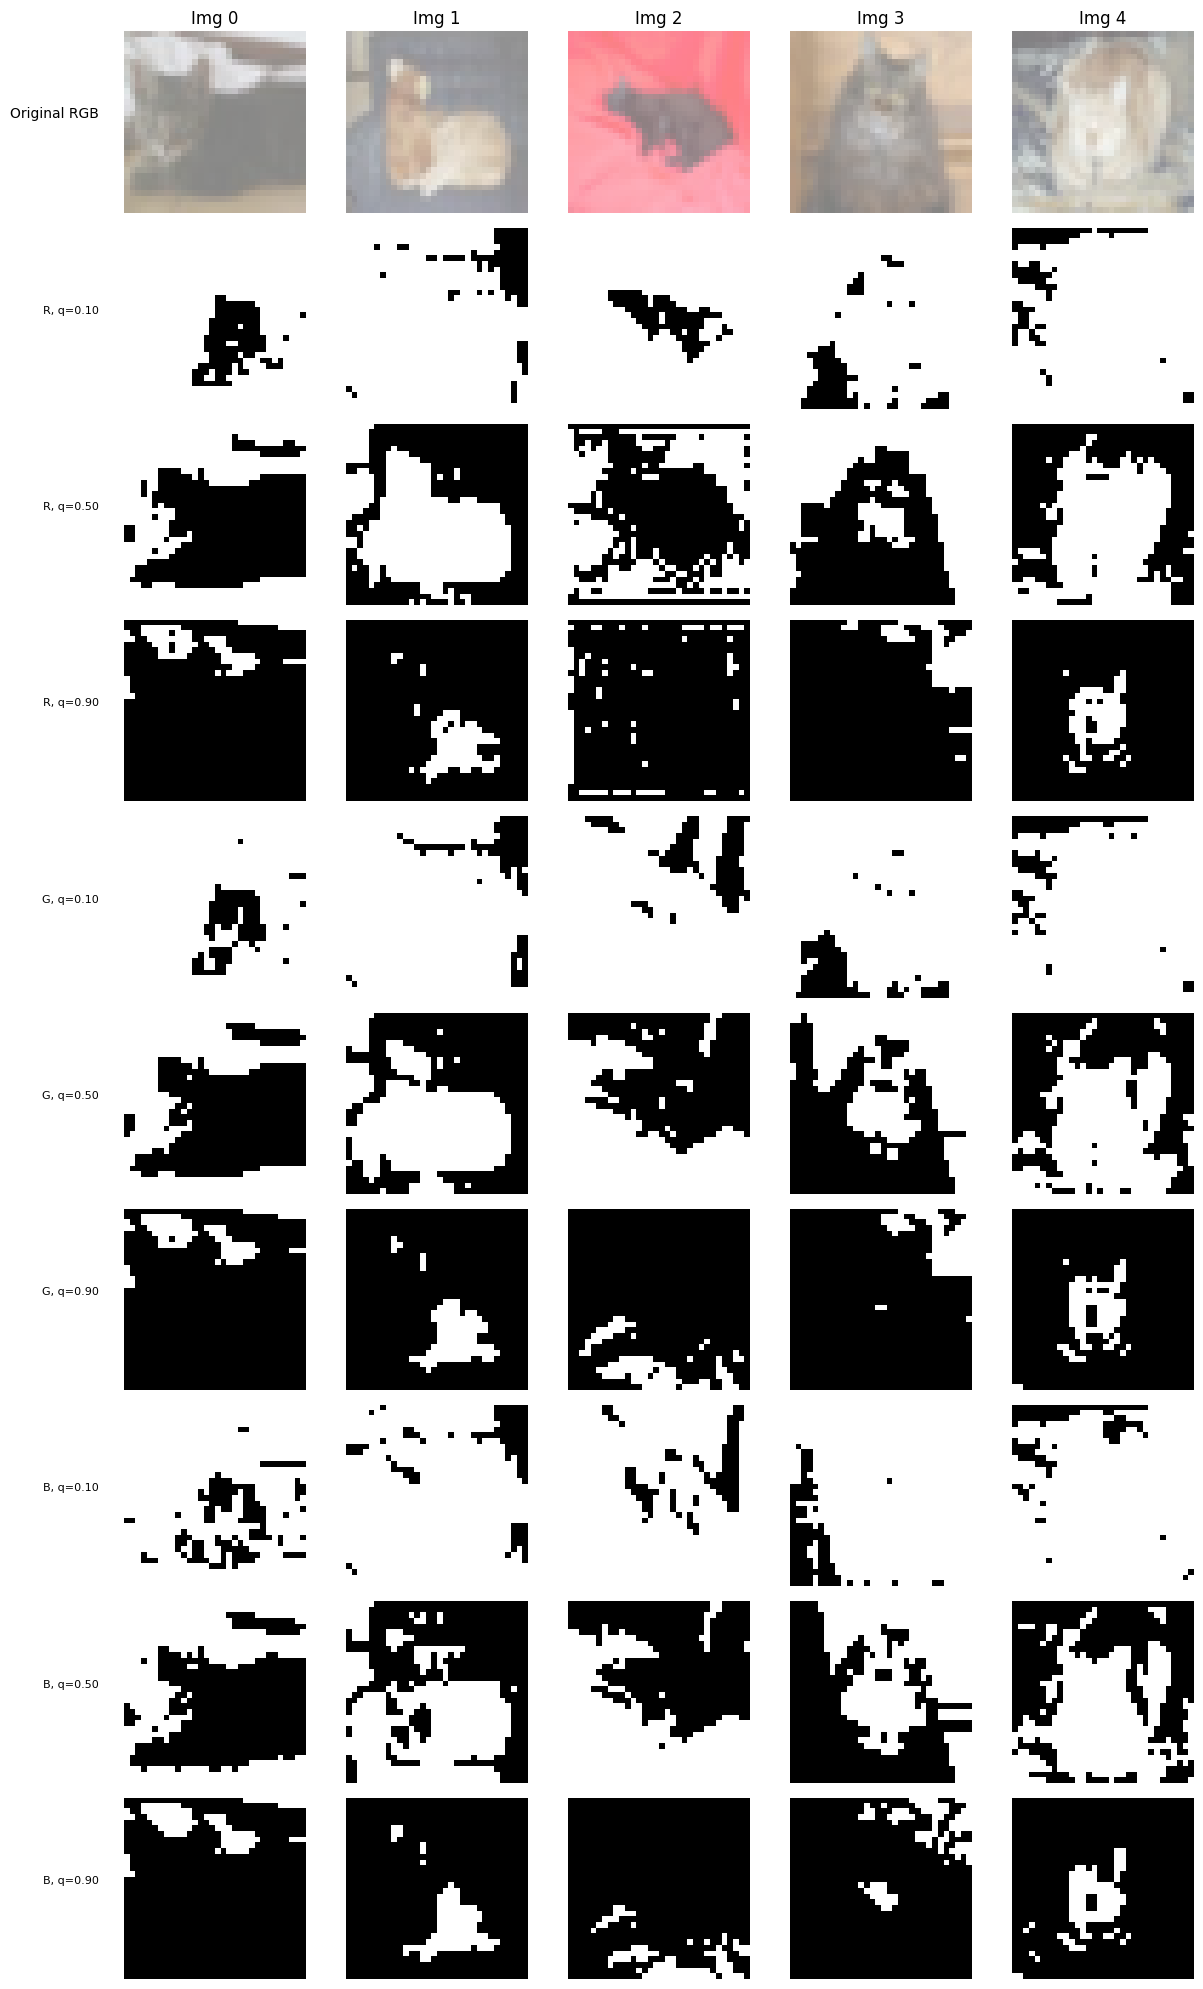

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import torch 

def plot_channel_binarization_rgb(data, quantiles, target_label=0, num_images=10, mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)):
    """
    Plots images binarized by image-specific quantiles applied INDEPENDENTLY 
    to each R, G, and B channel of the NORMALIZED image.
    
    Args:
        data: The dataset iterator (yielding PyTorch tensors).
        quantiles: List of floats (e.g., [0.1, 0.5, 0.9]).
        target_label: The class label to filter by.
        num_images: Number of images to display (columns).
        mean: Normalization mean. Used only for denormalization for the *display* of the original image.
        std: Normalization standard deviation. Used only for denormalization for the *display* of the original image.
    """
    
    CHANNELS = ['R', 'G', 'B']
    num_quantile_rows = len(quantiles)
    
    # 1 row for the Original RGB Image
    # 3 channels * num_quantile_rows for the binarized output
    num_rows = 1 + (len(CHANNELS) * num_quantile_rows) 
    
    plt.figure(figsize=(num_images * 2.5, num_rows * 2)) 
    
    count = 0
    for img_tensor, label in data:
        if label != target_label:
            continue
            
        # 1. Denormalize and Reshape for Original RGB Display (Context)
        mean_tensor = torch.tensor(mean).view(3, 1, 1)
        std_tensor = torch.tensor(std).view(3, 1, 1)
        
        # Denormalize for plotting the color image clearly
        img_denorm = (img_tensor * std_tensor) + mean_tensor
        img_denorm = torch.clamp(img_denorm, 0.0, 1.0) 
        # (C, H, W) -> (H, W, C) for Matplotlib
        img_rgb_display = img_denorm.permute(1, 2, 0).numpy()

        # 2. Get Normalized Channels for Processing
        # img_tensor is the normalized (C, H, W) tensor used for feature extraction
        img_channels = img_tensor.numpy() # Shape (3, H, W)
        
        # --- Plot Original RGB Image (Row 0) ---
        ax_orig = plt.subplot(num_rows, num_images, count + 1)
        plt.imshow(img_rgb_display) # Use denormalized image for context
        plt.axis('off')
        if count == 0:
            ax_orig.text(-5, 14, 'Original RGB', va='center', ha='right', fontsize=10)
        ax_orig.set_title(f'Img {count}')


        # 3. Process Channels Independently
        current_row = 1 # Start plotting binarized results from row 1
        
        for ch_idx, ch_name in enumerate(CHANNELS):
            channel_img = img_channels[ch_idx, :, :] # Normalized channel (H, W)
            
            # --- Get Channel-Specific Adaptive Thresholds ---
            
            # Use all values for thresholding, as they are normalized. 
            # We skip filtering for > 0.01 because the normalized data range is [-1, 1]
            non_nan_values = channel_img.flatten()
            
            if non_nan_values.size == 0:
                 thresholds = [0.0] * num_quantile_rows
            else:
                # Calculate quantile thresholds based on the normalized channel data
                thresholds = np.quantile(non_nan_values, quantiles) 

            # --- Apply Binarization for Each Quantile ---
            for q_idx, t in enumerate(thresholds):
                # Binarize: Values above threshold t become 1, others 0.
                bin_img = (channel_img > t).astype(int)
                
                plot_idx = current_row * num_images + count + 1
                ax = plt.subplot(num_rows, num_images, plot_idx)
                
                # Plot the binary image (black and white)
                plt.imshow(bin_img, cmap='gray')
                plt.axis('off')
                
                if count == 0:
                    label_text = f'{ch_name}, q={quantiles[q_idx]:.2f}'
                    ax.text(-5, 14, label_text, va='center', ha='right', fontsize=8)
                    
                current_row += 1 # Move to the next visualization row

        count += 1
        if count >= num_images:
            break
    
    plt.tight_layout()
    plt.show()

# Example of how you would call this function (assuming you have a PyTorch DataLoader named 'testloader'):
plot_channel_binarization_rgb(
    data=CIFAR10_train_data, 
    quantiles=[0.1, 0.5, 0.9], 
    target_label=3, # Example label
    num_images=5
)